# Regression model for snow depth in time lapse images

SnowEx Hackweek 2021 

*#cam_learning*

__Contributors:__ Marianne Cowherd, Danny Hogan, Katie Breen, Ching-ping Yu

### __Objectives:__

- Train a regression model for extracting snow depth from time-lapse imagery using supervised learning
- Evaluate model for accuracy 
- Test potential improvemnts (i.e. cropping images) and suggest ideas for next steps
- Learn ML!

### __Motivations:__

- 2020 SnowEx time-lapse imagery was labeled for snow-depth, but the process was time-consuming. 
- Automated methods exist using color thresholding and the Hough Transform, but background pixels add uncertainty.
- Computer vision may be able to detect the pole without including the background noise, and identify the snow depth information 
- 2017 SnowEx time-lapse has not been labeled, and a working ML model could be applied on these images

In [23]:
### insert moving video of all the camera images and snow depths underneath (Katie will add once she gets the code from Cassie)

### __Methods__

We will use the 2020 SnowEx timelapse from one camera (W1A) as our predictor and the corresponding snow depth measurements in the SnowEx SQL database as the response, to build a supervised model.

__1) Load packages for image and data table pre-processing, model development, and model evaluation__

In [1]:
# NOTE: this part of the tutorial uses additional libraries not in the default snowex jupyterhub
# mamba is a python package management alternative to conda and pip https://github.com/mamba-org/mamba
!mamba install -y -q tensorflow
!pip install opencv-python-headless 

  Package                     Version  Build               Channel                    Size
────────────────────────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────────────────────────────────────────────────────────────────

  _tflow_select                 2.3.0  mkl                 pkgs/main/linux-64         2 KB
  abseil-cpp               20200923.3  h9c3ff4c_0          conda-forge/linux-64     955 KB
  absl-py                      0.13.0  pyhd8ed1ab_0        conda-forge/noarch        97 KB
  astor                         0.8.1  pyh9f0ad1d_0        conda-forge/noarch        25 KB
  astunparse                    1.6.3  pyhd8ed1ab_0        conda-forge/noarch        15 KB
  dataclasses                     0.8  pyhc8e2a94_1        conda-forge/noarch         7 KB
  flatbuffers                   2.0.0  h9c3ff4c_0          conda-forge/linux-64       1 MB
  gast                          0.4.0  pyh9f0ad1d_0        conda-forge/noa

In [87]:

#### Load packages for machine learning
import tensorflow as tf  # end-to-end open source platform for machine learning

# from tensorflow.keras.datasets import cifar10
# keras is python and uses tensorflow in the backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

#### Packages for image processing and computer vision 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import geopandas as gpd
import datetime as dt
from datetime import datetime

from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import Image, ExifTags

### Packages for processing snow depth values using the SnowEx SQL database 
from snowexsql.db import get_table_attributes

import snowexsql.db
from snowexsql.data import PointData, SiteData
from snowexsql.conversions import query_to_geopandas
# Import the function to get connect to the db
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

import piexif
wd = os.getcwd()


__2. After loading the packages, we will load in the images from the Amazon Web Services S3. We will focus on one camera, W1A.__ 

In [4]:
%%capture
!aws s3 sync --no-progress s3://snowex-data/tutorial-data/camera-trap/ /tmp/camera-trap

In [41]:
## Load in the images 
filepath = '/tmp/camera-trap/W1A'
files = os.listdir(filepath)
files =  [filepath + '/' + str(f) for f in files]
image_data=[]

df = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])

for i in range(0,len(files)): 
    
    img = Image.open(files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df.loc[i]= [exif['DateTime'].date(),
                       files[i],
                       exif['DateTime'].time(),exif['DateTime'],np.nan]
    

for i,file in enumerate(files):
    # open image file and extract metadat
    img = Image.open(file) 
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    # convert date and time to datetime
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    # append list of tuples (not sure if this is any more efficient)
    image_data.append((exif['DateTime'].date(), file, exif['DateTime']))
# create image dataframe    

__3. Read in the images using cv2's imread function, then downscale the images to 200 x 200 pixels. 'pixels' is a list of all the images represented as an RGB array.__

In [43]:
pixels = []      
for i in range(0, len(df)):
    path = df['photo_id'][i]
    src = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # imread defaults to BGR order when reading pictures, for a reason?
    width =200
    height = 200 
    dsize = (width, height)
    # resize image
    output = cv2.resize(src, dsize)
    cv2.imwrite('tmp.jpg',output) 
    img2 = cv2.imread('tmp.jpg')
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)  # so we convert it back to RGB
    pixels.append(np.array(img2))

pixels = np.array(pixels)
print(pixels.shape) 
np.save('pixels_open.npy',pixels)
#print(pixels)


(659, 200, 200, 3)


In [9]:
pixels=np.load('pixels_open.npy')

array([[[[116, 151, 181],
         [114, 149, 179],
         [111, 146, 178],
         ...,
         [122, 154, 195],
         [125, 157, 196],
         [123, 155, 194]],

        [[114, 149, 179],
         [116, 151, 181],
         [119, 154, 186],
         ...,
         [125, 157, 198],
         [122, 154, 193],
         [122, 154, 193]],

        [[114, 149, 181],
         [118, 153, 185],
         [117, 151, 186],
         ...,
         [129, 161, 202],
         [125, 157, 196],
         [125, 157, 196]],

        ...,

        [[  0,   2,   0],
         [138, 143, 139],
         [  0,   1,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  1,   0,   2],
         [  0,   0,   0],
         [  2,   2,   2],
         ...,
         [  0,   0,   0],
         [  1,   1,   1],
         [  3,   3,   3]],

        [[  4,   0,   5],
         [  1,   0,   2],
         [  1,   0,   0],
         ...,
         [  0,   0,   0],
        

__4. Pull the snow depth values from the SnowEx SQL database__

In this case, we pulled all the data from the snow depth data from camera W1A.

In [44]:
# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(PointData)

# Grab the open site data from the db
open_site = 'W1A'
qry = session.query(PointData).filter(PointData.equipment.contains(open_site))
df_open = query_to_geopandas(qry,engine)

# Matach the time from the images to the depth in the database
df = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])
for i in range(0,len(files)): 
    
    img = Image.open(files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df.loc[i]= [exif['DateTime'].date(),
                       files[i],
                       exif['DateTime'].time(),exif['DateTime'],np.nan]
    
df_open['datetime'] = [datetime.combine(df_open['date'][i],df_open['time'][i]).replace(tzinfo=None) for i in range(len(df_open))]  # make the datetimes have the same time zone info


for i in range(len(df)):
    pivot = df['datetime'][i]
    items = df_open['datetime']
    tmp = np.where(items==pivot)[0]
    if len(np.where(items==pivot)[0])>0:
        idx = tmp[0]
        df['depth'][i] = df_open['value'][idx]
  

<ipython-input-44-eaee364b886d>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depth'][i] = df_open['value'][idx]


In [45]:
len(df.loc[df['depth']>0]) # remaining matched values

319

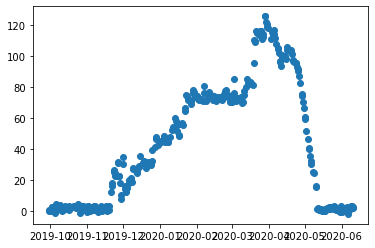

In [46]:
plt.plot(df['datetime'],df['depth'],'o')

__5. We will do the same as before but this time with cropped images. We will compare our results between the full images and the cropped images.__

We will collapse the code to save space. 

In [73]:
site_loc='W1A'
os.chdir('/home/jovyan/cam-learning/data')
wd = os.getcwd()
for filename in os.listdir('/tmp/camera-trap/'+site_loc):
    inpath = '/tmp/camera-trap/'+site_loc+'/'+filename
    outpath = f'/cropped/{site_loc}/'.join([wd,filename])
    #if path not in list(df['photo_id']):
    #    os.remove(path)
    #else:
    im = Image.open(inpath)

    #load exif data
    exif_dict = piexif.load(im.info["exif"])
    exif_bytes = piexif.dump(exif_dict)

    width, height = im.size
    # Setting the points for cropped image
    if site_loc == 'W1A':
        left = 3000
        top = 50
        right = 3400
        bottom = 0.63*height
    elif site_loc == 'W9A':
        left = 2100
        top = 150
        right = 2500
        bottom = height - 500
    else: break

    # Cropped image of above dimension
    # (It will not change original image)
    im = im.crop((left, top, right, bottom))

    # Save cropped images with exif data
    im.save(outpath, exif = exif_bytes)

cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
cropping
c

In [80]:
import glob
filepath = '/home/jovyan/cam-learning/data/cropped/W1A/'
cropped_files = glob.glob(filepath + '*.JPG')
# cropped_files = os.listdir('/home/jovyan/cam-learning/data/cropped/W1A/')
# cropped_files =  ['/home/jovyan/cam-learning/data/cropped/W1A/' + str(f) for f in cropped_files]

df_cropped = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])
for i in range(0,len(cropped_files)): 
    
    cropped_img = Image.open(cropped_files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in cropped_img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df_cropped.loc[i]= [exif['DateTime'].date(),
                       cropped_files[i],
                       exif['DateTime'].time(),exif['DateTime'],np.nan]
for i in range(len(df_cropped)):
    pivot = df_cropped['datetime'][i]
    items = df_open['datetime']
    tmp = np.where(items==pivot)[0]
    if len(np.where(items==pivot)[0])>0:
        idx = tmp[0]
        df_cropped['depth'][i] = df_open['value'][idx]

pixels_cropped = []      
for i in range(0, len(df_cropped)):
    path = df_cropped['photo_id'][i]
    src = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    width =200 
    height = 200 
    # dsize
    dsize = (width, height)
    # resize image
    output = cv2.resize(src, dsize)
    cv2.imwrite('tmp.jpg',output) 
    cropped_img2 = cv2.imread('tmp.jpg')
    cropped_img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    pixels_cropped.append(np.array(cropped_img2))

pixels_cropped = np.array(pixels_cropped)
# pixels_cropped =np.load('pixels_cropped_open.npy')

# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(PointData)

# Grab the open site data from the db
open_site = 'W1A'
qry = session.query(PointData).filter(PointData.equipment.contains(open_site))
df_open = query_to_geopandas(qry,engine)

# Matach the time from the images to the depth in the database
df_cropped = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])
for i in range(0,len(files)): 
    
    img = Image.open(files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df_cropped.loc[i]= [exif['DateTime'].date(),
                       files[i],
                       exif['DateTime'].time(),exif['DateTime'],np.nan]
    
df_open['datetime'] = [datetime.combine(df_open['date'][i],df_open['time'][i]).replace(tzinfo=None) for i in range(len(df_open))]


for i in range(len(df_cropped)):
    pivot = df_cropped['datetime'][i]
    items = df_open['datetime']
    tmp = np.where(items==pivot)[0]
    if len(np.where(items==pivot)[0])>0:
        idx = tmp[0]
        df_cropped['depth'][i] = df_open['value'][idx]

<ipython-input-80-11cdc4b67c83>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['depth'][i] = df_open['value'][idx]
<ipython-input-80-11cdc4b67c83>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['depth'][i] = df_open['value'][idx]



## save pixels for cropped images

In [132]:
pixels_cropped = []      
for i in range(0, len(df)):
    path = df_cropped['photo_id'][i]
    src = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # imread defaults to BGR order when reading pictures, for a reason?
    width =100
    height = 200 
    dsize = (width, height)
    # resize image
    output = cv2.resize(src, dsize)
    cv2.imwrite('tmp.jpg',output) 
    img2 = cv2.imread('tmp.jpg')
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)  # so we convert it back to RGB
    pixels_cropped.append(np.array(img2))

pixels_cropped = np.array(pixels_cropped)
print(pixels.shape) 
np.save('pixels_open_cropped.npy',pixels)
#print(pixels)


(659, 200, 200, 3)


__6. Flattening pixels data in a table.__

In [50]:
dataset_cropped = pixels_cropped.reshape((659,-1))
dataset_cropped = np.concatenate((dataset_cropped, np.array(df_cropped['depth']).reshape((659,1))),axis=1)
dataset_cropped = pd.DataFrame(dataset_cropped)
np.save('dataset_open_cropped.npy', dataset_cropped)


In [106]:

dataset = pixels.reshape((659,-1))
dataset = np.concatenate((dataset, np.array(df['depth']).reshape((659,1))),axis=1)
dataset=dataset[dataset[:,-1]>0]
dataset = pd.DataFrame(dataset)
np.save('dataset_open.npy', dataset)

<ipython-input-106-3c3b23ea495a>:3: RuntimeWarning: invalid value encountered in greater
  dataset=dataset[dataset[:,-1]>0]


In [135]:
# run this cell if you've already saved the dataset 
'''
dataset = np.load('dataset_open.npy',allow_pickle=True)
dataset = dataset[dataset[:,-1]>0]
'''
dataset_cropped = np.load('../data/dataset_open_cropped.npy',allow_pickle=True)


__7. Machine Learning Linear Regression.__

In [142]:
dataset_cropped = np.array(dataset_cropped)[np.array(dataset_cropped)[:,-1]>0]
dataset_cropped=pd.DataFrame(dataset_cropped)
dataset_cropped.shape

(319, 60001)

# four machine learning scenarios:
1. full image, linear regression
2. fill image, CNN
3. cropped image, linear regression
4. cropped image, CNN

In [108]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [109]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_dataset)
scaled_test = scaler.transform(test_dataset) ## fit_transform != transform. 
                                             ## transform uses the parameters of fit_transform

In [110]:
train_x, train_y = scaled_train[:, :-1], scaled_train[:, -1]
test_x, test_y = scaled_test[:, :-1], scaled_test[:, -1]

array([[0.19444444, 0.42771084, 0.80714286, ..., 0.        , 0.        ,
        0.        ],
       [0.63888889, 0.56024096, 0.82142857, ..., 0.        , 0.        ,
        0.        ],
       [0.09444444, 0.31927711, 0.61428571, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.33333333, 0.22891566, 0.25714286, ..., 0.        , 0.        ,
        0.        ],
       [0.36111111, 0.45180723, 0.87142857, ..., 0.        , 0.        ,
        0.        ],
       [0.52777778, 0.48192771, 0.67142857, ..., 0.        , 0.        ,
        0.        ]])

In [111]:
tf.random.set_seed(0) ## For reproducible results
linear_regression = tf.keras.models.Sequential() # Specify layers in their sequential order
# inputs are 4 dimensions (4 dimensions = 4 features)
# Dense = Fully Connected.  
linear_regression.add(tf.keras.layers.Dense(1, activation=None ,input_shape=(train_x.shape[1],)))
# Output layer has no activation with just 1 node

In [112]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
linear_regression.compile(optimizer = opt, loss='mean_squared_error')

In [113]:
print(linear_regression.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 120001    
Total params: 120,001
Trainable params: 120,001
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
%%time
# NOTE: can changed from epochs=150 to run faster, change to verbose=1 for per-epoch output
history =linear_regression.fit(train_x, train_y, epochs=20, validation_split = 0.2, verbose=0)

CPU times: user 5.67 s, sys: 9.87 s, total: 15.5 s
Wall time: 8.01 s


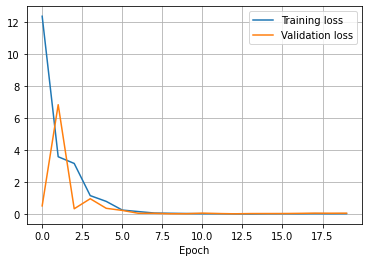

In [115]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Neural Net

In [119]:
tf.random.set_seed(1000)  ## For reproducible results
network = tf.keras.models.Sequential() # Specify layers in their sequential order
# inputs are 4 dimensions (4 dimensions = 4 features)
# Dense = Fully Connected.   
# First hidden layer has 1000 neurons with relu activations.
# Second hidden layer has 512 neurons with relu activations
# Third hidden layer has 256 neurons with Sigmoid activations
network.add(tf.keras.layers.Dense(1000, activation='relu' ,input_shape=(train_x.shape[1],)))
network.add(tf.keras.layers.Dense(512, activation='relu')) # sigmoid, tanh
network.add(tf.keras.layers.Dense(256, activation='sigmoid'))
# Output layer uses no activation with 1 output neurons
network.add(tf.keras.layers.Dense(1)) # Output layer

In [120]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
network.compile(optimizer = opt, loss='mean_squared_error')

In [121]:
%%time

# NOTE: if you have time, consider upping epochs -> 150
history = network.fit(train_x, train_y, epochs=5, validation_split = 0.2, verbose=0)

CPU times: user 1min 11s, sys: 18 s, total: 1min 29s
Wall time: 45.2 s


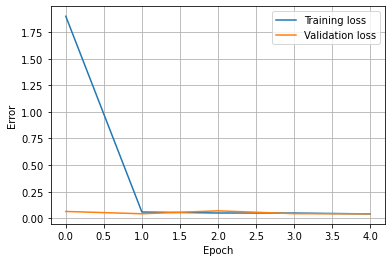

In [123]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

In [124]:
## Linear Regression

yhat_linReg = linear_regression.predict(test_x)
inv_yhat_linReg = np.concatenate((test_x, yhat_linReg), axis=1)
# inv_yhat_linReg = scaler.inverse_transform(inv_yhat_linReg)
inv_yhat_linReg = inv_yhat_linReg[:,-1]

## DNN
yhat_dnn = network.predict(test_x) 
inv_yhat_dnn = np.concatenate((test_x, yhat_dnn), axis=1)
# inv_yhat_dnn = scaler.inverse_transform(inv_yhat_dnn)
inv_yhat_dnn = inv_yhat_dnn[:,-1]

## True Snow Depth (Test Set)
inv_y = test_y


## Put Observed and Predicted (Linear Regression and DNN) in a Dataframe
prediction_df = pd.DataFrame({"Observed": inv_y,
                    "LR":inv_yhat_linReg, "DNN":inv_yhat_dnn})

In [131]:
# prediction_df['LR']

0    -52.521866
1    -48.799302
2     -4.378159
3    -28.156777
4     27.677698
        ...    
59   -10.013058
60     4.406244
61   -17.559301
62    -2.378327
63    -2.482051
Name: LR, Length: 64, dtype: float64

In [125]:
def metrics_print(test_data,test_predict):
    print('Test RMSE: ', round(np.sqrt(mean_squared_error(test_data, test_predict)), 2))
    print('Test R^2 : ', round((r2_score(test_data, test_predict)*100), 2) ,"%")
    print('Test MAPE: ', round(mean_absolute_percentage_error(test_data, test_predict)*100,2), '%')

In [126]:
print("##************** Linear Regression Results **************##")
metrics_print(prediction_df['Observed'], prediction_df['LR'])
print(" ")
print(" ")

print("##************** Deep Learning Results **************##")
metrics_print(prediction_df['Observed'], prediction_df['DNN'])
print(" ")
print(" ")

##************** Linear Regression Results **************##
Test RMSE:  41.79
Test R^2 :  -1717628.93 %
Test MAPE:  3.4339455785454976e+17 %
 
 
##************** Deep Learning Results **************##
Test RMSE:  47.86
Test R^2 :  -2253636.12 %
Test MAPE:  1.2981033472073594e+16 %
 
 


Text(0.5, 1.0, 'Deep Neural Network')

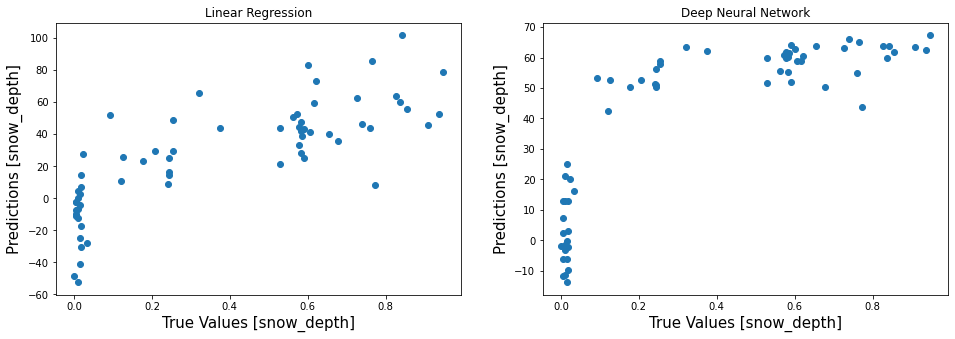

In [127]:
fa = plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.scatter(prediction_df['Observed'],prediction_df['LR'])
plt.xlabel('True Values [snow_depth]', fontsize=15)
plt.ylabel('Predictions [snow_depth]', fontsize=15)
plt.title("Linear Regression")


plt.subplot(1,2,2)
plt.scatter(prediction_df['Observed'],prediction_df['DNN'])
plt.xlabel('True Values [snow_depth]', fontsize=15)
plt.ylabel('Predictions [snow_depth]', fontsize=15)
plt.title("Deep Neural Network")


Text(0.5, 1.0, 'Deep Neural Network')

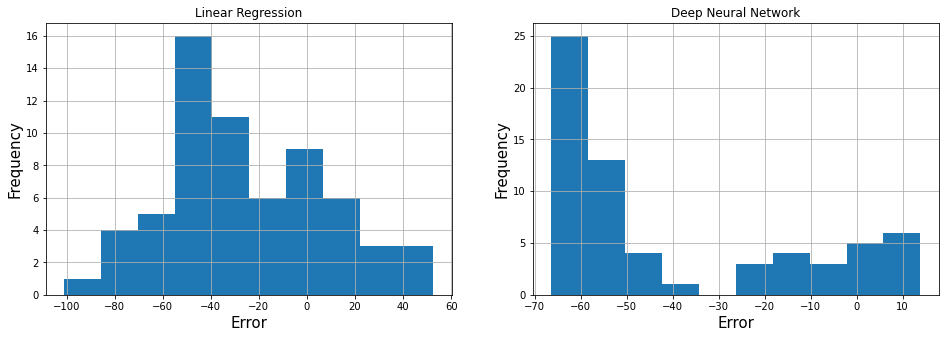

In [128]:
LR_error = prediction_df['Observed'] - prediction_df['LR']
DNN_error = prediction_df['Observed'] - prediction_df['DNN']

fa = plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
LR_error.hist()
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Linear Regression")

plt.subplot(1,2,2)
DNN_error.hist()
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Deep Neural Network")

In [143]:
train_dataset = dataset_cropped.sample(frac=0.8, random_state=0)
test_dataset = dataset_cropped.drop(train_dataset.index)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_dataset)
scaled_test = scaler.transform(test_dataset) ## fit_transform != transform. 
                                             ## transform uses the parameters of fit_transform
train_x, train_y = scaled_train[:, :-1], scaled_train[:, -1]
test_x, test_y = scaled_test[:, :-1], scaled_test[:, -1]

tf.random.set_seed(0) ## For reproducible results
linear_regression = tf.keras.models.Sequential() # Specify layers in their sequential order
# inputs are 4 dimensions (4 dimensions = 4 features)
# Dense = Fully Connected.  
linear_regression.add(tf.keras.layers.Dense(1, activation=None ,input_shape=(train_x.shape[1],)))
# Output layer has no activation with just 1 node

In [144]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
linear_regression.compile(optimizer = opt, loss='mean_squared_error')

In [145]:
%%time
# NOTE: can changed from epochs=150 to run faster, change to verbose=1 for per-epoch output
history =linear_regression.fit(train_x, train_y, epochs=20, validation_split = 0.2, verbose=0)

CPU times: user 4.27 s, sys: 8.14 s, total: 12.4 s
Wall time: 6.31 s


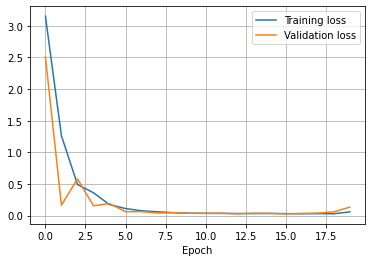

In [146]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

neural net for cropped

In [148]:
tf.random.set_seed(1000)  ## For reproducible results
network = tf.keras.models.Sequential() # Specify layers in their sequential order
# inputs are 4 dimensions (4 dimensions = 4 features)
# Dense = Fully Connected.   
# First hidden layer has 1000 neurons with relu activations.
# Second hidden layer has 512 neurons with relu activations
# Third hidden layer has 256 neurons with Sigmoid activations
network.add(tf.keras.layers.Dense(1000, activation='relu' ,input_shape=(train_x.shape[1],)))
network.add(tf.keras.layers.Dense(512, activation='relu')) # sigmoid, tanh
network.add(tf.keras.layers.Dense(256, activation='sigmoid'))
# Output layer uses no activation with 1 output neurons
network.add(tf.keras.layers.Dense(1)) # Output layer

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
network.compile(optimizer = opt, loss='mean_squared_error')

In [ ]:
%%time

# NOTE: if you have time, consider upping epochs -> 150
history = network.fit(train_x, train_y, epochs=50, validation_split = 0.2, verbose=0)

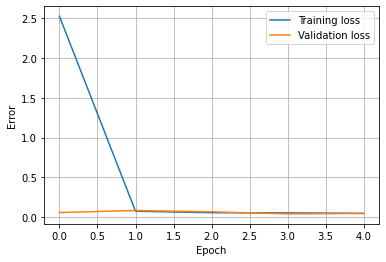

In [150]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

In [159]:
## Linear Regression

yhat_linReg = linear_regression.predict(test_x)
inv_yhat_linReg = np.concatenate((test_x, yhat_linReg), axis=1)
# inv_yhat_linReg = scaler.inverse_transform(inv_yhat_linReg)
inv_yhat_linReg = inv_yhat_linReg[:,-1]

## DNN
yhat_dnn = network.predict(test_x) 
inv_yhat_dnn = np.concatenate((test_x, yhat_dnn), axis=1)
# inv_yhat_dnn = scaler.inverse_transform(inv_yhat_dnn)
inv_yhat_dnn = inv_yhat_dnn[:,-1]

## True Snow Depth (Test Set)
inv_y = test_y


## Put Observed and Predicted (Linear Regression and DNN) in a Dataframe
prediction_df = pd.DataFrame({"Observed": inv_y,
                    "LR":inv_yhat_linReg, "DNN":inv_yhat_dnn})

In [160]:
print("##************** Linear Regression Results **************##")
metrics_print(prediction_df['Observed'], prediction_df['LR'])
print(" ")
print(" ")

print("##************** Deep Learning Results **************##")
metrics_print(prediction_df['Observed'], prediction_df['DNN'])
print(" ")
print(" ")

##************** Linear Regression Results **************##
Test RMSE:  0.34
Test R^2 :  -11.69 %
Test MAPE:  100838834176671.27 %
 
 
##************** Deep Learning Results **************##
Test RMSE:  0.21
Test R^2 :  58.59 %
Test MAPE:  25680550297881.46 %
 
 


Text(0.5, 1.0, 'Deep Neural Network')

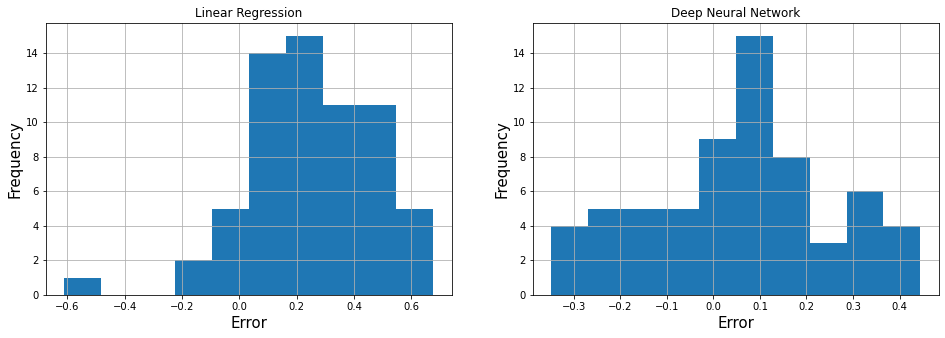

In [161]:
LR_error = prediction_df['Observed'] - prediction_df['LR']
DNN_error = prediction_df['Observed'] - prediction_df['DNN']

fa = plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
LR_error.hist()
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Linear Regression")

plt.subplot(1,2,2)
DNN_error.hist()
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Deep Neural Network")

Text(0.5, 1.0, 'Deep Neural Network')

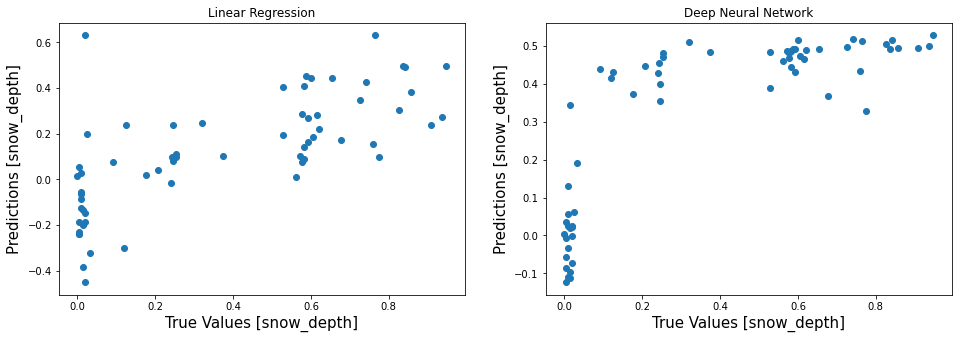

In [162]:
fa = plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.scatter(prediction_df['Observed'],prediction_df['LR'])
plt.xlabel('True Values [snow_depth]', fontsize=15)
plt.ylabel('Predictions [snow_depth]', fontsize=15)
plt.title("Linear Regression")


plt.subplot(1,2,2)
plt.scatter(prediction_df['Observed'],prediction_df['DNN'])
plt.xlabel('True Values [snow_depth]', fontsize=15)
plt.ylabel('Predictions [snow_depth]', fontsize=15)
plt.title("Deep Neural Network")
